In [1]:
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyxdf
import re
import seaborn as sns

In [20]:
datasrc = "/net/store/nbp/projects/GTI_decoding"
datafolder = "data/main/01_subjects_data"
gen_folder = "data/main/02_general_exp_data"

triggers = ['CueTimeStamp',
                'CueDisappearedTimeStamp',
                'ObjectShownTimeStamp',
                'BeepPlayedTimeStamp',
                'ButtonPressedTimeStamp']
eeg = 'openvibeSignal'
stimulus = 'ToolCueOrientationString'

tools = ['daisygrubber', 'fishscaler', 'flowercutter', 'fork', 'paintbrush',
       'paletteknife', 'screwdriver', 'spatula', 'spokewrench', 'trowel',
       'wrench', 'zester']

familiar = ['fork','trowel','screwdriver','spatula','paintbrush','wrench']
tool_fam_map = {t:('fam' if t in familiar else 'unfam') for t in tools}

event_mapping = {'task': 1,
                 'inter-task-object': 2,
                 'object': 3,
                 'action': 4,
                 'inter-trial':5 }

subjects = [f for f in os.listdir(os.path.join(datasrc,datafolder)) if re.match(r'S[\d]+', f)]

In [21]:
subjects

['S001', 'S002', 'S003', 'S004']

In [22]:
def get_streams(dxdf):
    trig_streams = [99] * len(triggers)
    eeg_stream = 99
    stim_stream = 99 
    
    for i in range(len(data)):
        if data[i]["info"]['name'][0] == eeg:
            eeg_stream = i
        elif data[i]["info"]['name'][0] == stimulus:
            stim_stream = i
        else:
            try:
                trig_streams[triggers.index(data[i]["info"]['name'][0])] = i
            except:
                pass
    return eeg_stream, stim_stream, trig_streams

def check_block_data(f,block,eeg_stream, stim_stream, trig_streams):
    if (eeg_stream == 99) |  (stim_stream == 99) | (99 in trig_streams):
        print(" {:<7s} {:>5d} All data not found. Skipped".format(f,block))
        print(eeg_stream,stim_stream, trig_streams )
        return False
    else:
        return True
    
def get_stimulus_from_header(dxdf,block,idx):
    tmplst = []
    for i in range(len(dxdf[idx]["time_series"])):
        tmp = {}
        tmp['block'] = block
        tmp['tool'] = dxdf[idx]["time_series"][i][0]
        tmp['cue'] = dxdf[idx]["time_series"][i][2]
        tmp['ori'] = dxdf[idx]["time_series"][i][3]
        tmp['familiarity'] = tool_fam_map[dxdf[idx]["time_series"][i][0]]
        tmplst.append(tmp)
    return tmplst

def get_event_triggers(dxdf,block,eeg_stream,trig_streams,event_map): # Extract the triggers and concatenate them
    tmpdfs = []
    evntlist = {desc:idx for idx, desc in event_map.items()}
    for i, stim_idx in enumerate(trig_streams):
        tmpdf = pd.DataFrame(data[stim_idx]["time_stamps"],columns=[evntlist[i + 1]])
        tmpdfs.append(tmpdf)
    
    tmpdf = pd.concat(tmpdfs,axis=1)
    tmpdf['block'] = block
    tmpdf = tmpdf.reset_index().rename(columns={'index':'trial_id'})
    
    return tmpdf

def extract_stimulus(tmpdf):
    tmpdf['check_field'] = tmpdf.apply(lambda x: "/".join([x['cue'],x['tool'],x['ori']]),axis=1)
    tmpdf['intra_block'] = tmpdf['block'] == tmpdf['block'].shift()
    tmpdf['eq'] = tmpdf['check_field'] == tmpdf['check_field'].shift()
    selection_mask = ~tmpdf['eq'] | ~tmpdf['intra_block'] 
    tmpdf = tmpdf.loc[selection_mask,:].reset_index(drop=True)
    tmpdf.drop(columns=['eq','check_field','intra_block'],axis=1,inplace=True)
    tmpdf = tmpdf.reset_index().rename(columns={'index':'trial_id'})
    return tmpdf

def gather_one_subject_data(trial_df,event_df):
    x = event_df.reset_index().drop(columns=['index','trial_id'],axis=1).reset_index().rename(columns={'index':'trial_id'})
    y = trial_df.merge(x,on=['trial_id','block'])
    task_t = y['inter-task-object'] - y['task']
    inter_task_object_t = y['object'] - y['inter-task-object']
    object_t = y['action'] - y['object']
    action_t = y['inter-trial'] - y['action']
    inter_trial_t = y['task'].shift(-1) - y['inter-trial']
    y['task'] = task_t
    y['inter-task-object'] = inter_task_object_t
    y['object'] = object_t
    y['action'] = action_t
    y['inter-trial'] = inter_trial_t
    block_change = y['block'] != y['block'].shift(-1)
    y.loc[block_change,'inter-trial'] = np.NaN
    
    return y

In [23]:
os.listdir(os.path.join(datasrc,datafolder,subjects[0],'xdf'))

['S001_block_1.xdf',
 'S001_block_2.xdf',
 'S001_block_3.xdf',
 'S001_block_4.xdf']

In [27]:
data_dict = [] #data structure to hold a info about the data collected
testdata = []
subjc_eegs = []
#print("Subject Batch Trials\n")
for s in subjects:
    fpath = os.path.join(datasrc,datafolder,s,'xdf')
    datafiles = os.listdir(fpath)
    datalist = []
    eventlist = []
    d = 0
    for fl in datafiles:
        tmp_dict = {}
        block = int(fl.split("_")[-1].rstrip(".xdf"))
        data, header = pyxdf.load_xdf(os.path.join(fpath,fl))
        eeg_stream, stim_stream, trig_streams = get_streams(data)
        if check_block_data(s,block,eeg_stream, stim_stream, trig_streams):
            datalist.extend(get_stimulus_from_header(data,block,stim_stream))
            eventlist.append(get_event_triggers(data,block,eeg_stream,trig_streams,event_mapping))
        tmp_dict['filename'] = fl
        tmp_dict['block'] = block
        tmp_dict['subj_id'] = s
        tmp_dict['eeg_stream'] = eeg_stream
        tmp_dict['stim_stream'] = stim_stream
        tmp_dict['trig_streams'] = trig_streams
        data_dict.append(tmp_dict)
        #print("{:<7s} {:>5d} {:<7d} ".format(f,block,eventlist[-1].shape[0]))     
        
    df = pd.DataFrame(datalist,columns=['block','tool','cue','ori','familiarity'])
    df['subj_id'] = s
    df = extract_stimulus(df)
    edf = pd.concat(eventlist)
    testdata.append(gather_one_subject_data(df,edf))


In [28]:
#save the experiment details
(pd.DataFrame(
    data_dict,
    columns=['filename','subj_id','block','subj_id','eeg_stream','stim_stream','trig_streams'])
    .to_csv(os.path.join(datasrc,gen_folder,"ExperimentDetails.csv"),index=False,header=True))

In [29]:
#create one dataframe with data of every trial for the whole experiment
subj_df = pd.concat(testdata)
#for each trial create the condition column
subj_df['condition'] = subj_df.apply(lambda x: "/".join([x['cue'],x['familiarity'],x['ori']]),axis=1)
#save the data
subj_df.to_csv(os.path.join(datasrc,gen_folder,"allTrialsData.csv"),index=False,header=True)

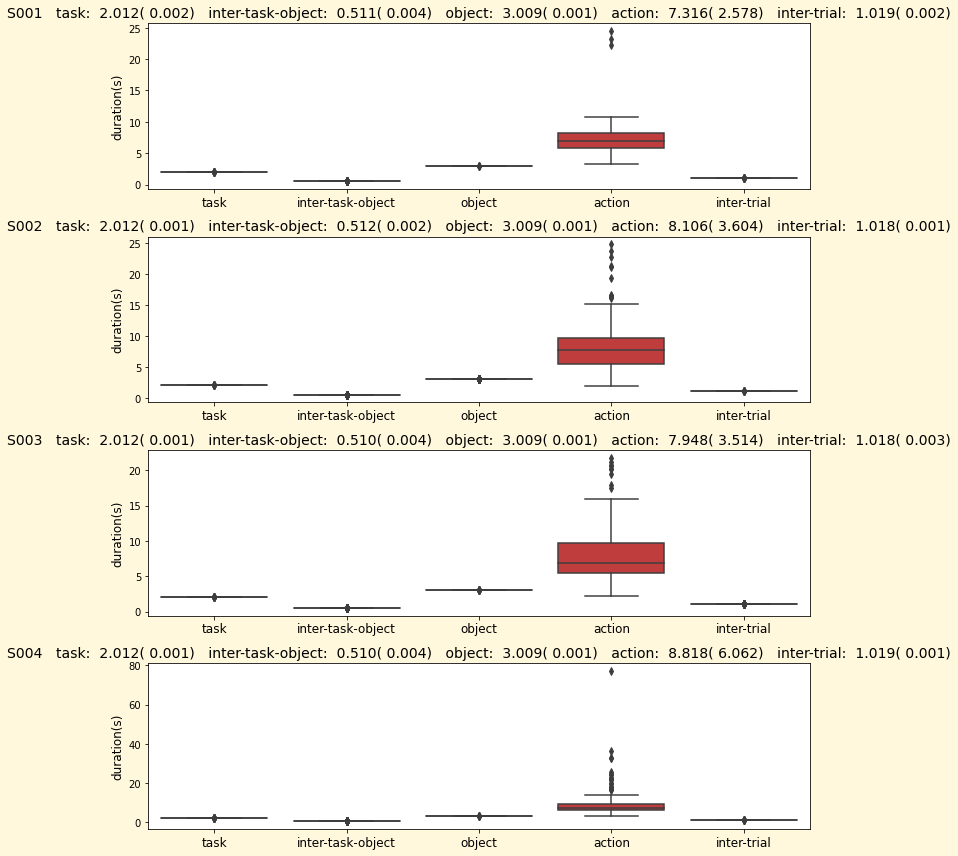

In [76]:
fig,ax = plt.subplots(len(subjects),1,figsize=(10,12),facecolor='cornsilk')
for i,s in enumerate(subjects):
    tmpdf = subj_df.loc[subj_df['subj_id']==s,['task','inter-task-object','object','action','inter-trial']]
    title = s
    for c in ['task','inter-task-object','object','action','inter-trial']:
        title += "   {}: {:6.3f}({:6.3f})".format(c,tmpdf[c].mean(),tmpdf[c].std())
    tmpdf = subj_df.loc[subj_df['subj_id']==s,['task','inter-task-object','object','action','inter-trial']].stack().reset_index(level=-1)
    tmpdf.rename(columns={'level_1':'interval',0:'duration'},inplace=True)
    sns.boxplot(data=tmpdf,x='interval',y='duration',ax=ax[i])
    ax[i].set_title(title,fontsize=14)
    ax[i].tick_params(axis='x', which='major', labelsize=12)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('duration(s)',fontsize=12)
plt.tight_layout()
plt.show()
    